In [ ]:
# Original Source : https://github.com/alod83/data-science/blob/master/DataAnalysis/Time%20Series%20Analysis.ipynb
# Additional Source(for future readings) : https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8

# 4 different approaches for Time Series Analysis
In this tutorial I illustrate how to analyse a time series, using the following 4 different approaches:
* Manual setting of model parameters and multi-step forecasting
* Manual setting of model parameters and single-step-forecasting
* Automatic setting of model parameters and multi-step forecasting
* Decomposition.

The first three approaches exploit differencing to make stationary the time series.

## Dataset import
Firstly, I import the dataset related to tourists arrivals to Italy from 1990 to 2019 and convert it into a time series. Data are extracted from the [European Statistics: Annual Data on Tourism Industries](https://ec.europa.eu/eurostat/web/tourism/data/database).
I load the dataset as a `pandas` dataframe.

In [1]:
import pandas as pd

df = pd.read_csv('data/tourists_tsa/tourist_arrivals.csv')
df.head()

,date,value
0,'2012-01-01',2343290
1,'2012-02-01',10468842
2,'2012-03-01',13908950
3,'2012-04-01',18456089
4,'2012-05-01',20294254


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    93 non-null     object
 1   value   93 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


## Build the Time Series
Now I convert the dataset into a time series, through the following two steps:
* the column containing dates must be converted to datetime. This can be done through the function `to_datetime()`, which converts a string into a datetime.
* set the index of the dataframe to the column containing dates. This can be done through the function `set_index()` applied to the dataframe.

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ts = df['value']
ts

date
2012-01-01     2343290
2012-02-01    10468842
2012-03-01    13908950
2012-04-01    18456089
2012-05-01    20294254
                ...   
2019-05-01    24832942
2019-06-01    34658825
2019-07-01    39123041
2019-08-01    41588218
2019-09-01    30253817
Name: value, Length: 93, dtype: int64

Before starting the analysis, I plot the time series. I use the `matplotlib` library.

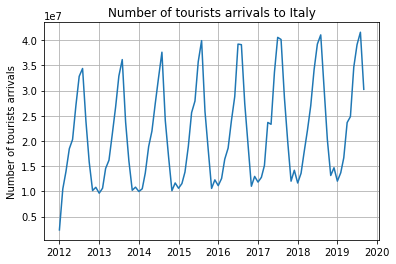

In [4]:
import matplotlib.pyplot as plt

plt.plot(ts)
plt.title('Number of tourists arrivals to Italy')
plt.ylabel('Number of tourists arrivals')
plt.grid()
plt.show()

## Time Series Splitting
Usually, when performing time series analysis, a time series is not split into training and test set, because all the time series is needed to get a good forecast. 

However, in this tutorial, I split the time series into two parts - training and test - in order to test the performance of the tested models. I take the first part of the time series as training set and the second part as test set. 

Each model will be trained on the trained set and tested on the test set.

In [5]:
ts_train = ts[:'2019-03-01']
ts_test = ts['2019-04-01':]

In [6]:
ts_train.shape, ts_test.shape

((87,), (6,))

## Check Stationarity
A stationary time series is a time series that has stable/constant statistical properties, such as mean and variance over time.

Long-term Forecasting is possible on a stationary time series. Thus, I must test whether the training time series is stationary or not. This can be done through the Augmented Dickey-Fuller Test, implemented by the `adfuller()` function of the `statsmodels` package. The `adfuller()` test returns the test statistics `adf`, the `pvalue` and the `critical_values`. The pvalue specifies whether the test result is meaningful or not. If `pvalue < alpha` then the test has sense, where `alpha` is a small value, e.g. `0.05`. 

In the Augmented Dickey-Fuller Test the null hypothesis is that the time series is not stationary. The null hypothesis is true if the test statistics `adf` is greater than critical values.
Thus, I define a function, called `check_stationarity()`, which checks whether a time series is stationary or not.

In [7]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [8]:
check_stationarity(ts_train)

The series is NOT stationary


Since the time series is not stationary, I transform it, by differencing once and I check again for stationarity.

In [9]:
ts_diff = ts_train.diff()
ts_diff.dropna(inplace=True)
check_stationarity(ts_diff)

The series is stationary


Now, the time series is stationary, thus I can set the difference order for the training model to 1.

In [10]:
d = 1

I plot the differenced time series

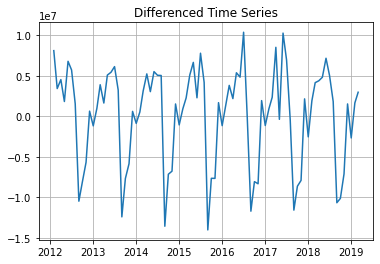

In [11]:
plt.plot(ts_diff)
plt.title('Differenced Time Series')
plt.grid()
plt.show()

## 1 - Manual setting of model parameters and multi-step forecasting
The first approach involves the use of the Seasonal Autoregressive Integrated Moving Average (SARIMA) model to forecast the number of tourists arrivals to Italy. 

The SARIMA model needs three parameters: p, d and q. The value of d has been already set, because it specifies the integration order needed to make the time series stationary. 

In this approach, I try to set the model p and q parameters by manually looking at the Partial Autocorrelation and Correlation graphs.

Partial Autocorrelation (PACF) is used to calculate the p parameter. I plot the PACF graph through the `statsmodels` function `plot_pacf()`. 

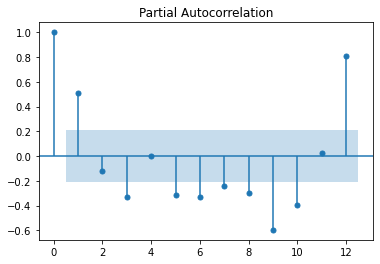

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(ts_diff, lags =12)
plt.show()

I note that the maximum value of PACF out the confidence intervals (in light blue) is 10. Thus, I try `p = 10`.

In [13]:
p = 10

Now I plot the Autocorrelation (ACF) graph to calculate the value of q. 

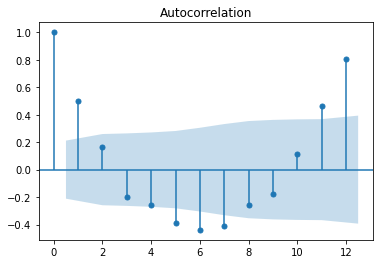

In [14]:
plot_acf(ts_diff, lags =12)
plt.show()

The maximum value of ACF out of confidence intervals is 11. However, I try to be more conservative and I try q = 7.

In [15]:
q = 7

Once set the p, q and d parameters, I can run the model. I exploit the `SARIMAX` model of the `statsmodels`. I create the model and I fit with the training time series. 

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ts_train, order=(p,d,q))
model_fit = model.fit()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed 

I can use the trained model for forecasting. I will exploit the model to forecast a number of steps equal to the length of the test time series.

In [17]:
n_test = ts_test.shape[0]
ts_pred = model_fit.forecast(steps=n_test)

Now I can plot the comparison between the test time series and the predicted values

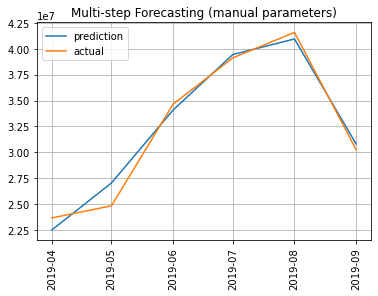

In [18]:
plt.plot(ts_pred, label='prediction')
plt.plot(ts_test, label='actual')
plt.title('Multi-step Forecasting (manual parameters)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

To evaluate the model, I calculate the Normalized Root Mean Square Error (NRMSE) metrics.

In [19]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(ts_pred, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.061856362384958716

## 2 - Manual setting of model parameters and single-step forecasting
In this case, I exploit the previous model for a single forecast (single step). Then I will retrain the model with the result of the forecast and I will perform another single forecast. And so on, up to reach the number of needed forecasts.

In [20]:
ts_train_step = ts_train
ts_pred_step = pd.Series()
for i in range(0, n_test):
    model_step = SARIMAX(ts_train_step, order=(p,d,q))
    model_step_fit = model_step.fit()
    current_pred = model_step_fit.forecast(steps=1)
    ts_train_step = ts_train_step.append(current_pred)
    ts_pred_step = ts_pred_step.append(current_pred)

<ipython-input-20-84f160eda2b2>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ts_pred_step = pd.Series()
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred freq

I calculate the NRMSE error.

In [21]:
nrmse = rmse(ts_pred_step, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.06210285673392676

I note that the single-step model behaves slightly worse than the multi-step. Probably, the single-step model works better for long-term forecasting. 

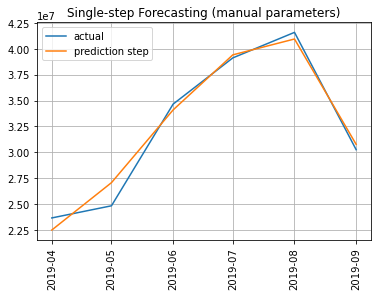

In [22]:
plt.plot(ts_test, label='actual')
plt.plot(ts_pred_step, label='prediction step')
plt.title('Single-step Forecasting (manual parameters)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

## 3 - Automatic setting of model parameters and multi-step forecasting

In this case, I exploit the `pmdarima` Python library for the automatic tuning of SARIMA p and q parameters. In detail, I exploit the `auto_arima()` function, which receives as input the test ranges for the p and q parameters, as well as other useful informations. I set `stepwise=False` in order to test all the possible combinations of p and q. In addition, I will set `seasonal=True` to use a SARIMA model.

In [23]:
import pmdarima as pm
stepwise_model = pm.auto_arima(ts_train,start_p=1, d=1, start_q=1,
                            max_p=12, max_q=12,
                            m=12,
                            seasonal=True, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
stepwise_model.fit(ts_train)

C:\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,0)(1,1,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "C:\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 690, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\Anaconda3\lib\site-packages\statsmodels\ba

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

Now I use the best model for forecast.

In [24]:
ts_pred_auto = stepwise_model.predict(n_periods=n_test)

I plot results.

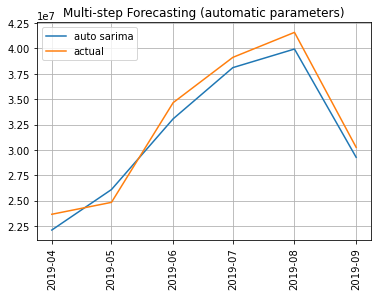

In [26]:
plt.plot(ts_test.index,ts_pred_auto, label='auto sarima')
plt.plot(ts_test, label='actual')
plt.title('Multi-step Forecasting (automatic parameters)')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

I calculate the NRMSE error.

In [27]:
nrmse = rmse(ts_pred_auto, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.07632379471612279

## 4 - Decomposition
With respect to the previous methods, this approach decompose the time series into its main components and then analyses each component separately.

Firstly, I decompose the training time series through the `seasonal_decompose()` function of the `statsmodels` library. I exploit the multiplicative decomposition. I obtain the trend, the seasonality and the residuals of the original time series. I also plot the decomposed time series.

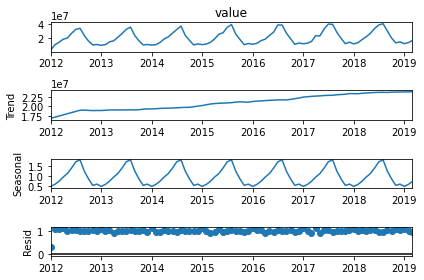

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decomposed = seasonal_decompose(ts_train,model='multiplicative',extrapolate_trend=True)

ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid
ts_decomposed.plot()
plt.show()

Now I analyse each component separately.

### Trend prediction
I will build a model based on the multi-step prediction. I check whether the trend time series is stationary. 

In [29]:
check_stationarity(ts_trend)

The series is NOT stationary


Since the trend time series is not stationary, I try to difference it.

In [30]:
ts_trend_diff = ts_trend.diff()
ts_trend_diff.dropna(inplace=True)
check_stationarity(ts_trend_diff)

The series is stationary


Now the trend time series is stationary, thus I can set d = 1.

In [31]:
d = 1

Similarly, to the multi-step forecast with automatic setting of parameters, I exploit the `auto_arima()` function, by specifying that the seasonality is false. In this case I will use an ARIMA model.

In [32]:
stepwise_model = pm.auto_arima(ts_trend,start_p=1, d=1, start_q=1,
                            max_p=12, max_q=12,
                            m=12,
                            seasonal=False, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
stepwise_model.fit(ts_trend)


C:\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True)

I use the best model for forecast.

In [33]:
trend_pred_auto = stepwise_model.predict(n_periods=n_test)

### Seasonality prediction
I repeat the same procedure for seasonality. I check for stationarity.

In [34]:
check_stationarity(ts_seasonal)

The series is stationary


The series is stationary, thus I set d = 0.

In [35]:
d = 0

I use the `auto_arima()` model with `seasonal=True` for a SARIMA model.

In [36]:
stepwise_model = pm.auto_arima(ts_seasonal,start_p=1, d=0, start_q=1,
                            max_p=12, max_q=12,
                            m=12,
                            seasonal=True, stationary=True,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
stepwise_model.fit(ts_seasonal)
seasonal_pred_auto = stepwise_model.predict(n_periods=n_test)

Now I can compose the original time series by calculating the product between the seasonal and the trend components

In [37]:
ts_pred_decompose = trend_pred_auto * seasonal_pred_auto 

I plot results.

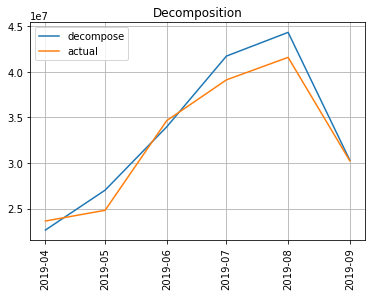

In [38]:
plt.plot(ts_test.index, ts_pred_decompose, label='decompose')
plt.plot(ts_test, label='actual')
plt.title('Decomposition')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

Finally, I calculate the RMSE error.

In [39]:
nrmse = rmse(ts_pred_decompose, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.10333835831041921